# Optimization of sartorious transfer paramters of viscous liquids guided by Baysesian Optimization

## Summary

This notebook objective is to generate new suggestions of aspiration and dispense rates that will minimize the tansfer error while minimizing the time of transfer of a viscous liquid. The code in this notebook will aim to optimize the liquid transfer parameters  to minimize the mean error from three volumes (default 300, 500, 1000) and the time of transfer to dispense 1000 uL.
The code is strucutred as follows:
1.  Fisrt section is for importing the relevant packages to perform BO, inclduing Pytorch and BOtorch
2.  Second section includes the definition of the BO_LiqTransfer class that includes the method optimized_suggestions() that generates BO optimized aspiration and dispense rate values for a particular data set.
3. Third section includes the code to initialize the automated platform.
4. Fourth section includes the code to run experiments using M1 robotic arm attached with electronic pipette, automated mass balance and BO optimization of a viscous liquid. The steps for the optimziation are:

    i. Initilize a BO_LiTransfer objecet and load initilization data using data_from_csv() method

    ii. Run optimized_suggestions() method

    iii. Run liquid transfer gravimetric experiment using the best suggestion for aspiration and dispense rates

    iv. Update latest %error obtained from the transfer using suggested aspiration and dispense rates.
    
    v. Iterate through steps ii-iV

## 1. Imports

In [1]:
# basic dependencies

import numpy as np
from numpy import loadtxt
from numpy import savetxt

import pandas as pd
import math
import time
from datetime import date

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

###########

# torch dependencies
import torch

tkwargs = {"dtype": torch.double, # set as double to minimize zero error for cholesky decomposition error
           "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")} # set tensors to GPU, if multiple GPUs please set cuda:x properly

torch.set_printoptions(precision=3)

###########

# botorch dependencies
import botorch

# data related
from botorch.utils.sampling import draw_sobol_samples
from botorch.utils.transforms import unnormalize, normalize

# surrogate model specific
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls.sum_marginal_log_likelihood import SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# qNEHVI specific
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.acquisition.multi_objective.monte_carlo import qNoisyExpectedHypervolumeImprovement

# utilities
from botorch.optim.optimize import optimize_acqf
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from typing import Optional
from torch import Tensor
from botorch.exceptions import BadInitialCandidatesWarning

from gpytorch.constraints import GreaterThan
from torch.optim import SGD
from gpytorch.mlls import ExactMarginalLogLikelihood

import warnings

warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# plotting dependencies
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


C:\Users\admin\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. BO_LiqTransfer class

In [2]:
class BO_LiqTransfer:

    def __init__(self, liquid_name):
        self.liquid_name = liquid_name
        self._data = None
        self.features = ['aspiration_rate','dispense_rate']
        self.objectives = ['%error','time_asp_1000']
        self.bmax = 1.25
        self.bmin = 0.1
        self._latest_suggestion = None
        self._latest_volume = None
        self._latest_acq_value = None
        self.mean_volumes = [300,500,1000]
    
   
    def set_data(self,df):
        df['time_asp_1000'] = 1000/df['aspiration_rate'] + 1000/df['dispense_rate'] + df['delay_aspirate'] + df['delay_dispense']
        if 'acq_value' not in df.columns:
            df['acq_value'] = None

        if df.loc[:,self.features].duplicated().sum()==0:
            df_mean = df
        else:
            df_duplicates = df.where(df.duplicated(self.features,keep=False)==True).dropna(how='all')
            df_incomplete = df.where(df.duplicated(self.features,keep=False)==False).dropna(how='all')
            df_mean = pd.DataFrame(columns= df.columns)
            for index,values in df_duplicates.drop_duplicates(self.features).iterrows():
                if len(df_duplicates.loc[index:index+2]) == len(self.mean_volumes):
                    mean_error =df_duplicates.loc[index:index+2,'%error'].abs().mean()
                    df_duplicates.loc[index,'%error'] = -mean_error
                    df_duplicates.loc[index, 'volume'] ='mean'+str(self.mean_volumes)
                    df_mean = pd.concat([df_mean,df.loc[index:index+2],df_duplicates.loc[[index]]])
                    
                else:
                    df_incomplete = pd.concat([df_incomplete,df_duplicates.loc[index:index+2]]).drop_duplicates()
            df_mean = pd.concat([df_mean,df_incomplete])
            df_mean = df_mean.reset_index(drop=True)    
        self._data = df_mean
 
        



    def data_from_csv(self,file_name):
        data = pd.read_csv(file_name)
        self.set_data(data)



    def update_data(self,df):
        self._latest_volume = df['volume'].iloc[-1]
        updated_data = pd.concat([self._data,df],ignore_index=True)
        self.set_data(updated_data)
        return self._data
                                

    def xy_split(self):
        df_train = self._data.where(self._data['volume']=='mean'+str(self.mean_volumes)).dropna(how='all')
        x_train = df_train[self.features]
        y_train = df_train[self.objectives]
        return x_train,y_train

    def set_bounds(self, x_train):
        return torch.vstack([x_train[0]*self.bmin, x_train[0]*self.bmax])



    def fit_surrogate(self):
        x_train, y_train = self.xy_split()
        x_train = torch.tensor(x_train.to_numpy(dtype=float), **tkwargs)
        y_train = torch.tensor(y_train.to_numpy(dtype=float), **tkwargs)
        y_train[:,0] = -torch.absolute(y_train[:,0])
        y_train[:,1] = -torch.absolute(y_train[:,1])

        problem_bounds = self.set_bounds(x_train)
        time_upper = 1000/problem_bounds[0][0] +1000/problem_bounds[0][1] + 10
        error_upper = y_train[:,0].abs().min()*1.25
        ref_point = torch.tensor([-error_upper,-time_upper], **tkwargs)

        train_x_gp = normalize(x_train, problem_bounds)
        models = []
        for i in range(y_train.shape[-1]):
            models.append(SingleTaskGP(train_x_gp, y_train[..., i : i + 1], outcome_transform=Standardize(m=1)))
        model1 = ModelListGP(*models)
        mll1 = SumMarginalLogLikelihood(model1.likelihood, model1)

        fit_gpytorch_model(mll1)
    
        return model1, ref_point, train_x_gp, problem_bounds
    
    def optimized_suggestions(self, random_state= 42):
        if random_state != None:
            torch.manual_seed(random_state) 
        standard_bounds = torch.zeros(2, len(self.features), **tkwargs)
        standard_bounds[1] = 1
        model1, ref_point, train_x_gp, problem_bounds = self.fit_surrogate()
        acq_func1 = qNoisyExpectedHypervolumeImprovement(
        model=model1,
        ref_point=ref_point, # for computing HV, must flip for BoTorch
        X_baseline=train_x_gp, # feed total list of train_x for this current iteration
        sampler=SobolQMCNormalSampler(sample_shape=512),  # determines how candidates are randomly proposed before selection
        objective=IdentityMCMultiOutputObjective(outcomes=np.arange(len(self.objectives)).tolist()), # optimize first n_obj col 
        prune_baseline=True, cache_pending=True)  # options for improving qNEHVI, keep these on
        sobol1 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
        sobol2 = draw_sobol_samples(bounds=standard_bounds,n=512, q=1).squeeze(1)
        sobol_all = torch.vstack([sobol1, sobol2])
            
        acq_value_list = []
        for i in range(0, sobol_all.shape[0]):
            with torch.no_grad():
                acq_value = acq_func1(sobol_all[i].unsqueeze(dim=0))
                acq_value_list.append(acq_value.item())
                
        # filter the best 12 QMC candidates first
        sorted_x = sobol_all.cpu().numpy()[np.argsort((acq_value_list))]
        qnehvi_x = torch.tensor(sorted_x[-12:], **tkwargs)  
        # unormalize our training inputs back to original problem bounds
        new_x =  unnormalize(qnehvi_x, bounds=problem_bounds)
        new_x = pd.DataFrame(new_x.numpy(),columns=['aspiration_rate','dispense_rate'])
        new_x['acq_value'] = sorted(acq_value_list, reverse=True)[:12]
        self._latest_suggestion = new_x[['aspiration_rate','dispense_rate']].iloc[0]
        self._latest_acq_value = new_x['acq_value'].iloc[0]
        return new_x
        





        
    
    


## 3. Initialization of automated plarform

In [3]:
#Import relevant python packages
import pandas as pd
import time
from matplotlib import pyplot as plt

from BO_liquid_transfer import BO_LiqTransfer       # shared class

from configs.SynthesisB1 import SETUP, LAYOUT_FILE

from controllably import load_deck      # optional
load_deck(SETUP.setup, LAYOUT_FILE)     # optional

platform = SETUP
platform.mover.verbose = False


Import: OK <controllably.misc.decorators>
Import: OK <controllably.misc.helper>
Import: OK <controllably.misc.factory>
Import: OK <controllably.misc.layout>
Import: OK <controllably.misc.logger>
Import: OK <controllably.misc.misc_utils>


Import: OK <controllably.Compound.compound_utils>
Import: OK <controllably.Compound.LiquidMover.liquidmover_utils>


Import: OK <controllably.Move.move_utils>
Import: OK <controllably.Move.Jointed.jointed_utils>
Import: OK <controllably.Move.Jointed.Dobot.dobot_utils>
Import: OK <controllably.Move.Jointed.Dobot.m1pro_utils>
Import: OK <controllably.Move.Jointed.Dobot.mg400_utils>
ClearError()
receive: ClearError()
EnableRobot()
receive: EnableRobot()
User(0)
receive: User(0)
Tool(0)
receive: Tool(0)
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
Infeasible coordinates! (0.0, 0.0, 200.0)
Infeasible coordinates! (300.0, 1.1368683772161603e-13, 0.0)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 3.000s (1.000x

In [4]:
#Initialization of variables for platfomr objects
pipette= platform.setup
deck = platform.setup.deck
balance = platform.balance
balance_deck = deck.slots['1']
source = deck.slots['2']
tip_rack = deck.slots['3']
bin = deck.slots['4']
pipette.mover.setSpeed(50)
print(balance_deck)
print(source)
print(tip_rack)
print(bin)


SpeedFactor(50)
receive: SpeedFactor(50)
Mass_balance_plastic_jar 1 Well Plate 15000 uL at Slot 1
Polyelectric 6 Well Plate 15000 ÂµL at Slot 2
Eppendorf Motion 96 Tip Rack 1000 ÂµL at Slot 3
Polyetric_bin at Slot 4


In [5]:
#Check if balance is connected
balance.zero()
balance.toggleRecord(True)
time.sleep(5)
print(balance.buffer_df.iloc[-1])
balance.toggleRecord(False)

Listening...
Zeroing... (5s)
Stop listening...
Zeroing complete.
Listening...
Time        2023-06-15 14:07:42.440589
Value                           238229
Factor                        6.862879
Baseline                 238221.791667
Mass                          1.050337
Name: 24, dtype: object
Stop listening...


In [178]:
#Stablish initial height of liquid on the source vial
pipette_name = 'rLine1000'
liquid_level = 12

In [6]:
pipette.attachTip()

Tip capacitance: 247
A1
Tip capacitance: 247
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.200x)
[300.000 0.000 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(198.894071,-3.942538,200.000000,10.000000,0.000000,0.000000)
Move time: 2.022s (0.500x)
[198.894 -3.943 200.000], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(198.894071,-3.942538,65.400000,10.000000,0.000000,0.000000)
Move time: 6.730s (0.200x)
[198.894 -3.943 65.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(1)
receive: SpeedFactor(1)
MovJ(198.894071,-3.942538,45.400000,10.000000,0.000000,0.000000)
Move time: 20.000s (0.010x)
[198.894 -3.943 45.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(198.894071,-3.942538,162.300000,10.000000,0.000000,0.000000)
Move time: 5.845s (0.200x)
[198.894 -3.943 162.300], [10  0  0]
SpeedFactor(50)
receive: 

array([325.100, 80.650, 105.900])

## 4. Guided BO optimization
i.   Create BO_LiqTransfer object and load data set.

Please set liquid name and volume to transfer according to the experiment.

In [12]:
# Change according to experiment
std = '1275'
liquid_name = 'Viscosity_std_' + std 
density = 0.8736
# Do not change
liq = BO_LiqTransfer(liquid_name)
# folder = (r"C:\Users\admin\Documents\GitHub\viscosity_liquid_transfer_Pablo\Sartorious_experiments\Initialisation_Data")
liq.data_from_csv(liquid_name+'_BOTorch_exp3.csv')
liq._data

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,Transfer_Observation,Comment,iteration,time_asp_1000,acq_value
0,Viscosity_std_1275,rLine1000,1000,28.915134,28.915134,False,10,10,0,0.8736,132.773934,0.788634,-9.725963,Incomplete aspiration and dispense,Blowout before,1.0,89.167931,NaN
1,Viscosity_std_1275,rLine1000,500,28.915134,28.915134,False,10,10,0,0.8736,97.980054,0.365575,-16.305995,Incomplete aspiration and dispense,Blowout before,1.0,89.167931,NaN
2,Viscosity_std_1275,rLine1000,300,28.915134,28.915134,False,10,10,0,0.8736,84.264670,0.202553,-22.713117,Incomplete aspiration and dispense,Blowout before,1.0,89.167931,NaN
3,Viscosity_std_1275,rLine1000,"mean[300, 500, 1000]",28.915134,28.915134,False,10,10,0,0.8736,132.773934,0.788634,-16.248358,Incomplete aspiration and dispense,Blowout before,1.0,89.167931,NaN
4,Viscosity_std_1275,rLine1000,1000,36.143918,36.143918,False,10,10,0,0.8736,119.593486,0.612891,-29.843014,Incomplete aspiration and dispense,Blowout before,2.0,75.334345,NaN
5,Viscosity_std_1275,rLine1000,500,36.143918,36.143918,False,10,10,0,0.8736,91.498749,0.369757,-15.348596,Incomplete aspiration and dispense,Blowout before,2.0,75.334345,NaN
6,Viscosity_std_1275,rLine1000,300,36.143918,36.143918,False,10,10,0,0.8736,80.366316,0.200310,-23.569327,Incomplete aspiration and dispense,Blowout before,2.0,75.334345,NaN
7,Viscosity_std_1275,rLine1000,"mean[300, 500, 1000]",36.143918,36.143918,False,10,10,0,0.8736,119.593486,0.612891,-22.920312,Incomplete aspiration and dispense,Blowout before,2.0,75.334345,NaN
8,Viscosity_std_1275,rLine1000,1000,2.891513,36.143918,False,10,10,0,0.8736,436.806757,0.746786,-14.516293,Incomplete aspiration and dispense,Blowout before,3.0,393.506829,NaN
9,Viscosity_std_1275,rLine1000,500,2.891513,36.143918,False,10,10,0,0.8736,250.100245,0.383848,-12.122796,Incomplete aspiration and dispense,Blowout before,3.0,393.506829,NaN


In [ ]:
# Change according to experiment
std = '1275'
liquid_name = 'Viscosity_std_' + std 
density = 0.8736
# Do not change
liq = BO_LiqTransfer(liquid_name)
folder = (r"C:\Users\admin\Documents\GitHub\viscosity_liquid_transfer_Pablo\Sartorious_experiments\Initialisation_Data")
liq.data_from_csv(folder+r'/'+'Initialisation_'+std+'.csv')
liq._data


ii.   Run BO_LiqTransfer.optimized_suggestions() method to obtain optimized aspiration and dispense rates.



In [175]:
liq.optimized_suggestions()


,aspiration_rate,dispense_rate,acq_value
0,4.598680,5.893073,20.023648
1,3.046256,8.090406,17.444141
2,6.763741,4.534260,16.805879
3,3.576697,5.436771,16.032632
4,2.897256,6.246523,8.313303
5,7.217901,3.263739,4.000453
6,6.590486,3.728913,3.788310
7,5.143265,4.026819,1.897878
8,3.325001,4.039127,1.076737
9,5.204203,3.418965,0.406388


In [176]:
liquids_dict = {
  liquid_name :{
        "rLine1000": {
            "aspiration_rate": liq._latest_suggestion['aspiration_rate'], 
            "dispense_rate": liq._latest_suggestion['dispense_rate'], 
            "blow_out" : False, 
            "delay_aspirate" : 10, 
            "delay_dispense" : 10, 
            "delay_blow_out" : 0, 
            },
    }

}

iii. Run liquid transfer using the best suggestion for aspiration and dispense rates in OT2 notebook.


In [11]:
pipette.mover.setHandedness(False)
pipette.mover.safeMoveTo(source.wells['A1'].top)

SetArmOrientation(0,1,1,1)
receive: SetArmOrientation(0,1,1,1)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[206.843 -146.682 200.000], [10  0  0]
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (1.000x)
[206.843 -146.682 200.000], [10  0  0]
MovJ(206.843094,-146.682146,73.510000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[206.843 -146.682 73.510], [10  0  0]


True

In [209]:
#define volume
volume = 300
#Check if new tip is required
pipette.mover.setHandedness(False)
pipette.mover.setSpeed(50)

if pipette.liquid.isTipOn()== False:
    pipette.attachTip()

#Transfer start
start = time.time()

#Aspirate step
pipette.mover.safeMoveTo(source.wells['A1'].from_bottom((0,0,liquid_level-5)))
pipette.liquid.aspirate(volume, speed=liquids_dict[liquid_name][pipette_name]['aspiration_rate'])
time.sleep(liquids_dict[liquid_name][pipette_name]['delay_aspirate'])

pipette.touchTip(source.wells['A1'])

#Dispense step
pipette.mover.safeMoveTo(balance_deck.wells['A1'].from_top((0,0,-5)))

balance.tare()
balance.clearCache()
balance.toggleRecord(True)
time.sleep(5)


pipette.liquid.dispense(volume, speed=liquids_dict[liquid_name][pipette_name]['dispense_rate'])

time.sleep(liquids_dict[liquid_name][pipette_name]['delay_dispense'])

#Blowout step
if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
    pipette.liquid.blowout(home=False)
    time.sleep(liquids_dict[liquid_name][pipette_name]['delay_blow_out'])

#Transfer termination
finish = time.time()
time_m = finish - start

pipette.mover.safeMoveTo(source.wells['A1'].top)
time.sleep(5)
balance.toggleRecord(False)
if liquids_dict[liquid_name][pipette_name]['blow_out'] == True:
    pipette.liquid.home()

#Do blowout
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()
time.sleep(5)
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()
time.sleep(5)
pipette.liquid.blowout(home=False)
time.sleep(5)
pipette.touchTip(source.wells['A1'])
pipette.liquid.home()


Tip capacitance: 249
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[206.843 -146.682 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (0.500x)
[206.843 -146.682 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,53.288957,10.000000,0.000000,0.000000)
Move time: 1.467s (1.000x)
[206.843 -146.682 53.289], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Aspirating 300.0 uL...
Target: 300.0 uL at 4.598679533895417 uL/s...
Best parameters: SpeedParameters(preset=150, intervals=12, step_size=10, delay=5.269676487000137)
SpeedParameters(preset=150, intervals=12, step_size=10, delay=5.269676487000137)
Speed 1: 150 uL/s
Aspiration time: 65.24202609993517s
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(206.843094,-146.682146,63.510000,10.000000,0.000000,0.000000)
M

'ok'

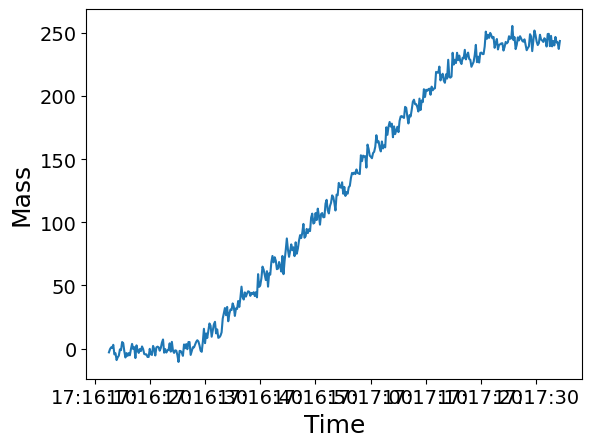

In [210]:
fig,axs = plt.subplots()

axs.plot(balance.buffer_df['Time'],balance.buffer_df['Mass'])

axs.set_xlabel('Time')
axs.set_ylabel('Mass')

plt.show()

In [211]:
#Record trasnfer values 

m = (balance.buffer_df.iloc[-10:,-1].mean()-balance.buffer_df.iloc[:10,-1].mean())/1000 #-1: mass column #-10: = last 10 rows #:10 = first 10 rows
error = (m-density*volume/1000)/(density/1000*volume)*100

#New dataframe
df = pd.DataFrame(columns = ['liquid', 'pipette', 'volume', 'aspiration_rate', 'dispense_rate','blow_out', 'delay_aspirate', 'delay_dispense', 'delay_blow_out', 'density', 'time', 'm', '%error', 'acq_value', 'Transfer_Observation', 'Comment'])
df = df.astype({'liquid':str,'pipette':str,'blow_out':bool,'Transfer_Observation':str,'Comment':str})
df = pd.concat([df,pd.DataFrame(liquids_dict[liquid_name][pipette_name],index=[0])],ignore_index=True)
df.iloc[-1,-6] = time_m
df.iloc[-1,2] = volume
df.iloc[-1, 0] = liquid_name
df.iloc[-1, 1] = pipette_name
df.iloc[-1,-7] = density
df.iloc[-1, -5] = m
df.iloc[-1,-4]= error
df.iloc[-1, -3] = liq._latest_acq_value

In [212]:
#Update liquid level
#liquid_level = liquid_level - 1*volume/1000
liquid_level = liquid_level - 1.2*m/density

In [213]:
liquid_level 

8.44219915750647

In [214]:
#Observe error made
df.tail(20)

,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,acq_value,Transfer_Observation,Comment
0,Viscosity_std_1275,rLine1000,300,4.59868,5.893073,False,10,10,0,0.8736,180.01778,0.245159,-6.45624,20.023648,NaN,NaN


In [207]:
#Assign category of observation of transfer such as Incomplete Dispense, Incomplete Aspiration, 
#Incomplete Aspiration and Dispense, Complete Transfer. 
#Comment if any unexpected exprimental mistakes or changes were performed that have to be taken into account.
#Incomplete Aspiration and Dispense, Complete Transfer. 
df.iloc[-1,-2]= 'Complete Transfer'
df.iloc[-1,-1]= 'Blowout before'

iv. Update latest %error obtained from the transfer using suggested aspiration and dispense rates.

In [208]:
liq.update_data(df) 


,liquid,pipette,volume,aspiration_rate,dispense_rate,blow_out,delay_aspirate,delay_dispense,delay_blow_out,density,time,m,%error,Transfer_Observation,Comment,iteration,time_asp_1000,acq_value
0,Viscosity_std_1275,rLine1000,1000,28.915134,28.915134,False,10,10,0,0.8736,132.773934,0.788634,-9.725963,Incomplete aspiration and dispense,Blowout before,1.0,89.167931,NaN
1,Viscosity_std_1275,rLine1000,500,28.915134,28.915134,False,10,10,0,0.8736,97.980054,0.365575,-16.305995,Incomplete aspiration and dispense,Blowout before,1.0,89.167931,NaN
2,Viscosity_std_1275,rLine1000,300,28.915134,28.915134,False,10,10,0,0.8736,84.26467,0.202553,-22.713117,Incomplete aspiration and dispense,Blowout before,1.0,89.167931,NaN
3,Viscosity_std_1275,rLine1000,"mean[300, 500, 1000]",28.915134,28.915134,False,10,10,0,0.8736,132.773934,0.788634,-16.248358,Incomplete aspiration and dispense,Blowout before,1.0,89.167931,NaN
4,Viscosity_std_1275,rLine1000,1000,36.143918,36.143918,False,10,10,0,0.8736,119.593486,0.612891,-29.843014,Incomplete aspiration and dispense,Blowout before,2.0,75.334345,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,Viscosity_std_1275,rLine1000,"mean[300, 500, 1000]",8.118998,3.422264,False,10,10,0,0.8736,479.066122,0.854714,-4.164858,Complete Transfer,Blowout before,NaN,435.372142,14.053769
64,Viscosity_std_1275,rLine1000,1000,4.598680,5.893073,False,10,10,0,0.8736,450.436554,0.855108,-2.11681,Complete Transfer,Blowout before,NaN,407.144472,20.023648
65,Viscosity_std_1275,rLine1000,500,4.598680,5.893073,False,10,10,0,0.8736,256.965867,0.427036,-2.235234,Complete Transfer,Blowout before,NaN,407.144472,20.023648
66,Viscosity_std_1275,rLine1000,300,4.598680,5.893073,False,10,10,0,0.8736,179.371426,0.247564,-5.538872,Complete Transfer,Blowout before,NaN,407.144472,20.023648


v. Iterate trhough last two code cells.

In [174]:
#save after each standard-experiment iteration
liq._data.to_csv(liquid_name+'_BOTorch_exp3.csv', index = False)

In [215]:
pipette.ejectTipAt(bin.wells['A1'].top)
pipette.mover.home()

Tip capacitance: 247
SetArmOrientation(1,1,1,1)
receive: SetArmOrientation(1,1,1,1)
MovJ(320.000000,-240.000000,73.510000,10.000000,0.000000,0.000000)
Move time: 2.263s (0.500x)
[320.000 -240.000 73.510], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(320.000000,-240.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 6.325s (0.200x)
[320.000 -240.000 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 8.699s (0.500x)
[232.616 194.961 200.000], [10  0  0]
SpeedFactor(20)
receive: SpeedFactor(20)
MovJ(232.616399,194.960923,114.400000,10.000000,0.000000,0.000000)
Move time: 4.280s (0.200x)
[232.616 194.961 114.400], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(232.616399,194.960923,200.000000,10.000000,0.000000,0.000000)
Move time: 0.856s (1.000x)
[232.616 194.961 200.000], [10  0  0]
SpeedFactor(50)
MovJ(300.000000,0.000000,200.00

False

In [76]:
pipette.liquid.eject()

'ok'

In [ ]:
pipette.mover.connect()

In [ ]:

liq._data


In [ ]:
pipette.liquid.dispense(1000)

In [177]:
pipette.mover.home()

SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(206.843094,-146.682146,200.000000,10.000000,0.000000,0.000000)
Move time: 1.265s (1.000x)
[206.843 -146.682 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 2.934s (0.500x)
[300.000 0.000 200.000], [10  0  0]
SpeedFactor(100)
receive: SpeedFactor(100)
MovJ(300.000000,0.000000,200.000000,10.000000,0.000000,0.000000)
Move time: 0.000s (1.000x)
[300.000 0.000 200.000], [10  0  0]
SpeedFactor(50)
receive: SpeedFactor(50)
Homed


True

In [ ]:
pipette.liquid.connect()

In [ ]:
balance.connect()

In [ ]:
std = '1275'
liquid_name = 'Viscosity_std_' + std 
density = 0.8736
# Do not change
liq = BO_LiqTransfer(liquid_name)
folder = (r"C:\Users\admin\Documents\GitHub\viscosity_liquid_transfer_Pablo\Sartorious_experiments\Initialisation_Data")
liq.data_from_csv(liquid_name+'_BOTorch_exp3.csv')
liq._data